In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.datasets import make_spd_matrix
from scipy import stats
sns.set_style("whitegrid")
from sklearn.covariance import LedoitWolf, OAS

# General Investigation of Covariance Matrices

Risk models have a systematic tendency to underpredict the risk of optimized portfolios

In [2]:
# K: Number of assets
K_assets = 50

# T: Number of observations
T_obs = 100

# N: Number of Monte Carlo simulation trials
N_trials = 100

print(f"Number of Assets (K): {K_assets}")
print(f"Number of Observations (T): {T_obs}")
print(f"K/T Ratio: {K_assets / T_obs:.2f}\n")

Number of Assets (K): 50
Number of Observations (T): 100
K/T Ratio: 0.50



In [3]:
results = []
eigenvalue_biases = []

for i in range(N_trials):
    # 1. Define a "True World"
    cov_true = make_spd_matrix(n_dim=K_assets, random_state=i)
    # Scale it to have an average volatility of ~20%
    avg_vol = np.sqrt(np.mean(np.diag(cov_true)))
    cov_true = cov_true * (0.20**2) / (avg_vol**2)

    # 2. Sample from the World
    # Generate T observations of multivariate returns for our K assets
    mean_vec = np.zeros(K_assets)
    returns = np.random.multivariate_normal(mean_vec, cov_true, size=T_obs)

    # 3. Estimate a Model
    # Calculate the sample covariance matrix from the generated returns
    cov_pred = np.cov(returns, rowvar=False, ddof=1)

    # 4. Optimize
    # Find the Minimum Variance Portfolio
    try:
        inv_cov_pred = np.linalg.inv(cov_pred)
        ones = np.ones(K_assets)
        w_unscaled = inv_cov_pred @ ones
        w_optimal = w_unscaled / w_unscaled.sum()
    except np.linalg.LinAlgError:
        # If the matrix is singular (can happen if T < K), skip this trial.
        continue

    # 5. Calculate Predicted vs. True Risk
    # Predicted volatility (in-sample)
    pred_var = w_optimal.T @ cov_pred @ w_optimal
    sigma_pred = np.sqrt(pred_var)

    # True volatility (out-of-sample)
    true_var = w_optimal.T @ cov_true @ w_optimal
    sigma_true = np.sqrt(true_var)

    # Store results
    results.append({
        'trial': i,
        'sigma_pred': sigma_pred,
        'sigma_true': sigma_true,
    })

    # --- Eigenfactor Analysis ---
    # Analyze the bias in the eigenvalues themselves
    evals_true, _ = np.linalg.eigh(cov_true) 
    evals_pred, _ = np.linalg.eigh(cov_pred) 
    
    # The ratio of true to predicted eigenvalues
    eigenvalue_biases.append(evals_true / evals_pred)

results_df = pd.DataFrame(results)
results_df['bias_ratio'] = results_df['sigma_true'] / results_df['sigma_pred']

In [4]:
# Theoretical bias factor from Shepard's formula
theoretical_bias = 1 / (1 - K_assets / T_obs)

print("--- Portfolio Volatility Bias Summary ---")
print(f"Theoretical Bias (1 / (1 - K/T)): {theoretical_bias:.4f}")
print(f"Mean Empirical Bias (σ_true / σ_pred): {results_df['bias_ratio'].mean():.4f}\n")

print("Summary Statistics for Volatilities:")
summary = results_df[['sigma_pred', 'sigma_true', 'bias_ratio']].describe()
print(summary)

--- Portfolio Volatility Bias Summary ---
Theoretical Bias (1 / (1 - K/T)): 2.0000
Mean Empirical Bias (σ_true / σ_pred): 2.0060

Summary Statistics for Volatilities:
       sigma_pred  sigma_true  bias_ratio
count  100.000000  100.000000  100.000000
mean     0.010467    0.020868    2.006031
std      0.004341    0.008445    0.230629
min      0.002017    0.004450    1.529121
25%      0.007345    0.013431    1.828813
50%      0.010997    0.023928    2.015149
75%      0.014148    0.027694    2.207990
max      0.017991    0.034297    2.484390


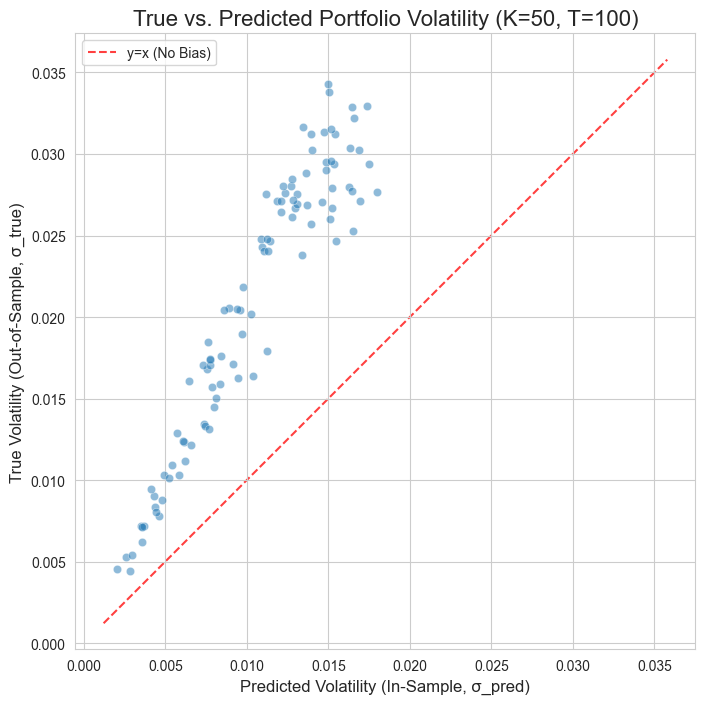

In [5]:
plt.figure(figsize=(8, 8))
ax = sns.scatterplot(data=results_df, x='sigma_pred', y='sigma_true', alpha=0.5)

lims = [
    np.min([ax.get_xlim(), ax.get_ylim()]),
    np.max([ax.get_xlim(), ax.get_ylim()]),
]
ax.plot(lims, lims, 'r--', alpha=0.75, zorder=0, label='y=x (No Bias)')

plt.title(f'True vs. Predicted Portfolio Volatility (K={K_assets}, T={T_obs})', fontsize=16)
plt.xlabel('Predicted Volatility (In-Sample, σ_pred)', fontsize=12)
plt.ylabel('True Volatility (Out-of-Sample, σ_true)', fontsize=12)
plt.legend()
plt.axis('equal')
plt.show()

Every single point lies above the red dashed line (y=x), meaning in every single trial, σ_true > σ_pred. This is a systematic bias: The optimizer always produces a portfolio that looks better in-sample than it performs out-of-sample.

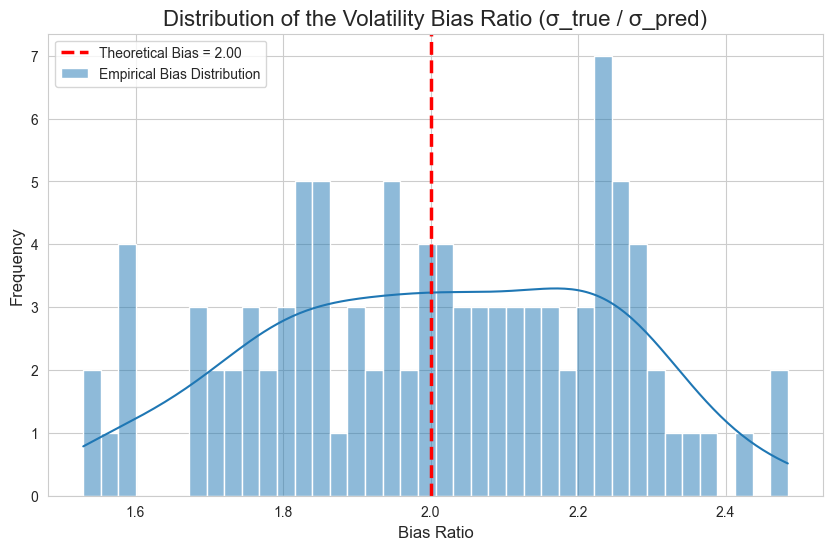

In [6]:
plt.figure(figsize=(10, 6))
sns.histplot(results_df['bias_ratio'], kde=True, bins=40, label='Empirical Bias Distribution')
plt.axvline(theoretical_bias, color='r', linestyle='--', linewidth=2.5, label=f'Theoretical Bias = {theoretical_bias:.2f}')

plt.title('Distribution of the Volatility Bias Ratio (σ_true / σ_pred)', fontsize=16)
plt.xlabel('Bias Ratio', fontsize=12)
plt.ylabel('Frequency', fontsize=12)
plt.legend()
plt.show()

The distribution of the empirical bias is centered right on top of the theoretical value predicted by Shepard's formula.

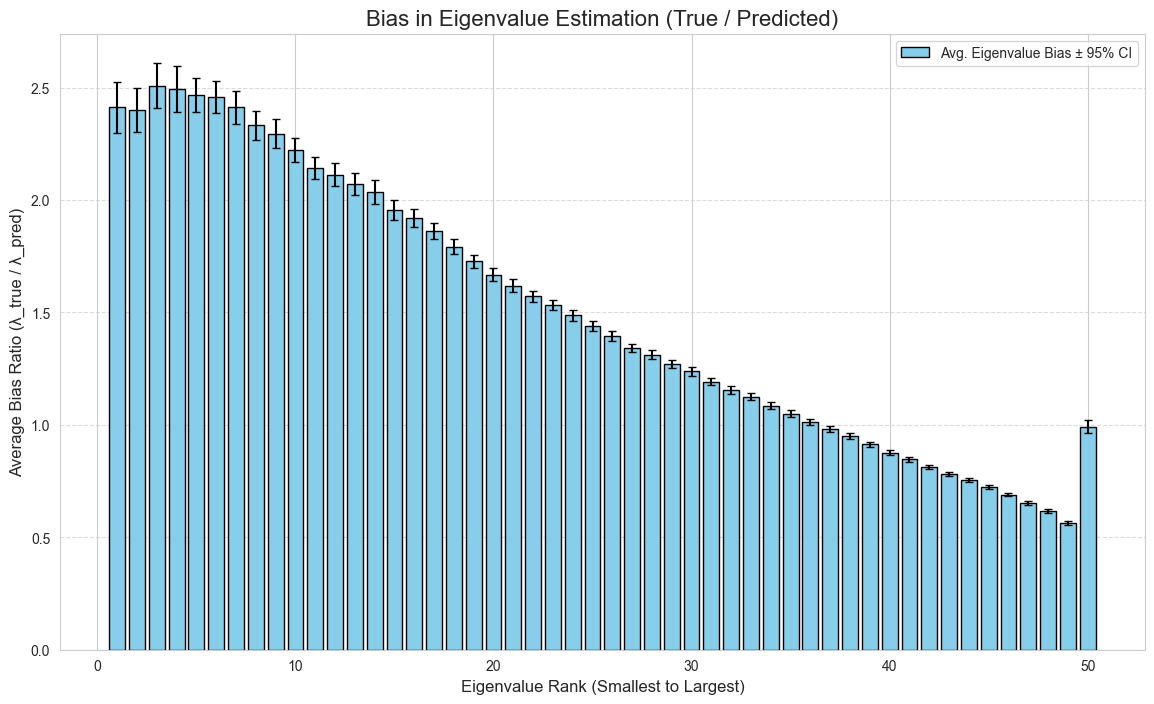

In [7]:
eigenvalue_biases = np.array(eigenvalue_biases)

avg_eigen_bias = np.mean(eigenvalue_biases, axis=0)
eigen_idx = np.arange(1, K_assets + 1)

std_err_eigen_bias = stats.sem(eigenvalue_biases, axis=0)

confidence_level = 0.95

z_score = stats.norm.ppf((1 + confidence_level) / 2)

margin_of_error = z_score * std_err_eigen_bias

plt.figure(figsize=(14, 8))
plt.bar(eigen_idx, avg_eigen_bias, 
        yerr=margin_of_error, capsize=3, 
        color='skyblue', edgecolor='black',
        label='Avg. Eigenvalue Bias ± 95% CI')

plt.title('Bias in Eigenvalue Estimation (True / Predicted)', fontsize=16)
plt.xlabel('Eigenvalue Rank (Smallest to Largest)', fontsize=12)
plt.ylabel('Average Bias Ratio (λ_true / λ_pred)', fontsize=12)
plt.legend()
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

The optimization process overweights assets that appear to be good hedges. This means the optimizer is latching onto the eigenvectors (or "eigenportfolios") of the covariance matrix that have spuriously low eigenvalues (variances).
1.	Smallest eigenvalues (ranks 1–5)
-	Bias ratios peak around 2.3–2.6.
-	The sample covariance severely under-estimates the tiny true eigenvalues.
2.	Large eigenvalues (ranks ~30–45)
-	Ratios drop below 1, down to about 0.6.
-	The sample covariance over-estimates the big true eigenvalues (it inflates the dominant factors).
3.	Largest eigenvalue (rank 50)
-	The ratio swings back closer to 1.0.
-	Common boundary effect in high-dimensional covariance estimation. 

This calls for shrinkage!

1. Linear (Eigenvalue) Shrinkage: Shrink each eigenvalue toward the grand mean $\bar\lambda$:
$$\lambda_i^{(\alpha)} = \alpha\,\bar\lambda \;+\;(1-\alpha)\,\lambda_i,\quad \alpha\in[0,1],
\quad \widehat\Sigma_{\rm LS} = V\,\mathrm{diag}\bigl(\lambda_i^{(\alpha)}\bigr)\,V^\top.$$
2. Eigenvalue Clipping: Floor small eigenvalues at a fraction f of the mean:
$$\lambda_i^{(\mathrm{clip})} = \max\bigl(\lambda_i,\;f\,\bar\lambda\bigr),\quad f\in(0,1),
\quad \widehat\Sigma_{\rm clip} = V\,\mathrm{diag}\bigl(\lambda_i^{(\mathrm{clip})}\bigr)\,V^\top.$$
3. Ledoit–Wolf Shrinkage: Shrink toward a scaled identity target
$$\;F=\tfrac{\mathrm{tr}(\widehat\Sigma)}{K}\,I \\
\widehat\Sigma_{\rm LW} = \delta^\star\,F \;+\;(1-\delta^\star)\,\widehat\Sigma, \quad
with \quad
\delta^\star
=\frac{\displaystyle\sum_{i\neq j}\mathrm{Var}\bigl(\widehat\Sigma_{ij}\bigr)}
{\displaystyle\sum_{i\neq j}\bigl(\widehat\Sigma_{ij}-F_{ij}\bigr)^2}\,.$$
4. Oracle Approximating Shrinkage (OAS): Also toward $F=\tfrac{\mathrm{tr}(\widehat\Sigma)}{K}I$, but with a closed-form intensity
$$\widehat\Sigma_{\rm OAS}
= \rho^\star\,F \;+\;(1-\rho^\star)\,\widehat\Sigma,
\quad
\rho^\star
=\frac{(1-\tfrac{2}{K})\,\mathrm{tr}(\widehat\Sigma^2)+\mathrm{tr}^2(\widehat\Sigma)}
{(T+1-\tfrac{2}{K})\bigl[\mathrm{tr}(\widehat\Sigma^2)-\tfrac{\mathrm{tr}^2(\widehat\Sigma)}{K}\bigr]}\,.$$

In [8]:
def eigen_shrink_linear(cov, lam=0.5):
    """Linear shrinkage of eigenvalues toward their mean."""
    evals, evecs = np.linalg.eigh(cov)
    avg = np.mean(evals)
    shrunk = lam * evals + (1 - lam) * avg
    return evecs @ np.diag(shrunk) @ evecs.T

def eigen_shrink_clip(cov, floor_factor=0.1):
    """Floor small eigenvalues at a fraction of the mean eigenvalue."""
    evals, evecs = np.linalg.eigh(cov)
    floor = floor_factor * np.mean(evals)
    shrunk = np.clip(evals, floor, None)
    return evecs @ np.diag(shrunk) @ evecs.T

K_assets = 50
T_obs = 100
N_trials = 100

methods = ['sample', 'linear_shrink', 'clipping', 'ledoit_wolf', 'oas']

eigen_bias = {m: [] for m in methods}
vol_bias = {m: [] for m in methods}

for i in range(N_trials):
    rng = np.random.default_rng(seed=i)
    # True covariance
    A = rng.standard_normal((K_assets, K_assets))
    cov_true = A @ A.T
    cov_true *= (0.20**2) / (np.mean(np.diag(cov_true)))
    # Sample returns and sample cov
    returns = rng.multivariate_normal(np.zeros(K_assets), cov_true, size=T_obs)
    cov_sample = np.cov(returns, rowvar=False, ddof=1)
    evals_true, _ = np.linalg.eigh(cov_true)

    lw = LedoitWolf().fit(returns).covariance_
    oas_cov = OAS().fit(returns).covariance_
    
    for m in methods:
        # Shrink covariance
        if m == 'sample':
            cov_shr = cov_sample
        elif m == 'linear_shrink':
            cov_shr = eigen_shrink_linear(cov_sample, lam=0.5)
        elif m == 'clipping':
            cov_shr = eigen_shrink_clip(cov_sample, floor_factor=0.1)
        elif m == 'ledoit_wolf':
            cov_shr = lw
        elif m == 'oas':
            cov_shr = oas_cov
        
        # Eigenvalue bias
        evals_shr, _ = np.linalg.eigh(cov_shr)
        eigen_bias[m].append(np.mean(evals_true / evals_shr))
        
        # Portfolio weights and volatility bias
        try:
            w = np.linalg.solve(cov_shr, np.ones(K_assets))
            w /= w.sum()
            sigma_pred = np.sqrt(w.T @ cov_shr @ w)
            sigma_true = np.sqrt(w.T @ cov_true @ w)
            vol_bias[m].append(sigma_true / sigma_pred)
        except np.linalg.LinAlgError:
            continue

# Aggregate means
mean_eigen = {m: np.round(np.mean(eigen_bias[m]), 3) for m in methods}
mean_vol = {m: np.round(np.mean(vol_bias[m]), 3) for m in methods}

df = pd.DataFrame({
    'mean_eigenvalue_bias': mean_eigen,
    'mean_volatility_bias': mean_vol
})
df

,mean_eigenvalue_bias,mean_volatility_bias
sample,1.441,2.016
linear_shrink,0.780,0.834
clipping,1.068,1.198
ledoit_wolf,0.800,0.852
oas,0.799,0.851


Heavy-Tail scenario

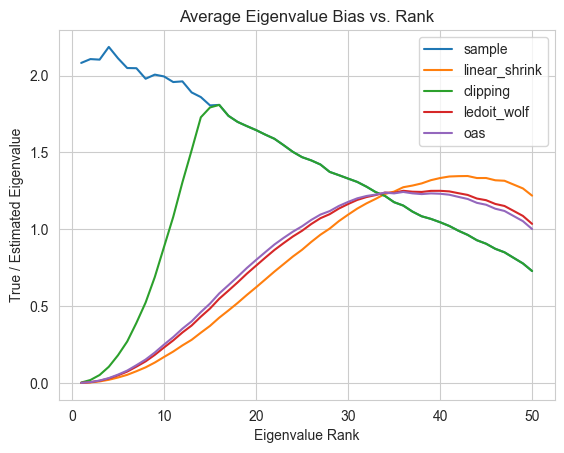

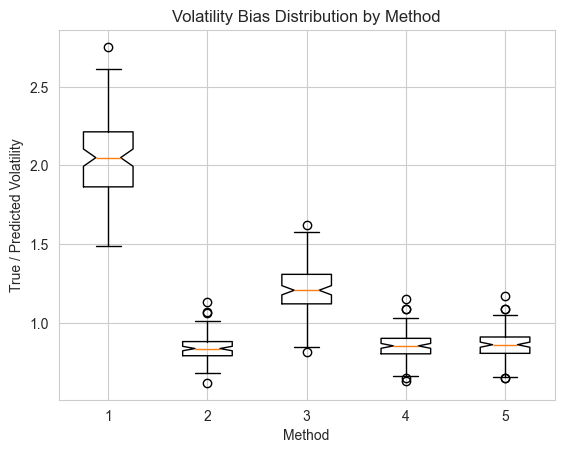

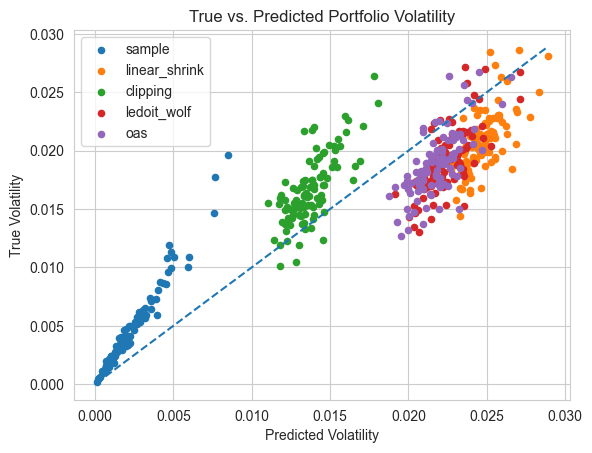

In [9]:
df = 5

eigen_ratio = {m: np.zeros((N_trials, K_assets)) for m in methods}
vol_pred = {m: [] for m in methods}
vol_true = {m: [] for m in methods}

for i in range(N_trials):
    rng = np.random.default_rng(seed=i)
    # True covariance
    A = rng.standard_normal((K_assets, K_assets))
    cov_true = A @ A.T
    cov_true *= (0.20 / np.sqrt(np.mean(np.diag(cov_true))))**2
    
    # Heavy-tail returns via multivariate Student's t
    x = rng.standard_t(df, size=(T_obs, K_assets))
    x *= np.sqrt((df - 2) / df)
    L = np.linalg.cholesky(cov_true)
    returns = x @ L.T
    
    # Sample covariance
    cov_sample = np.cov(returns, rowvar=False, ddof=1)
    evals_true, _ = np.linalg.eigh(cov_true)
    
    lw_cov = LedoitWolf().fit(returns).covariance_
    oas_cov = OAS().fit(returns).covariance_
    
    for m in methods:
        if m == 'sample':
            cov_shr = cov_sample
        elif m == 'linear_shrink':
            cov_shr = eigen_shrink_linear(cov_sample, lam=0.5)
        elif m == 'clipping':
            cov_shr = eigen_shrink_clip(cov_sample, floor_factor=0.1)
        elif m == 'ledoit_wolf':
            cov_shr = lw_cov
        elif m == 'oas': 
            cov_shr = oas_cov
        
        evals_shr, _ = np.linalg.eigh(cov_shr)
        eigen_ratio[m][i, :] = evals_true / evals_shr
        
        # MV portfolio vol
        try:
            w = np.linalg.solve(cov_shr, np.ones(K_assets))
            w /= w.sum()
            sigma_pred = np.sqrt(w.T @ cov_shr @ w)
            sigma_true = np.sqrt(w.T @ cov_true @ w)
            vol_pred[m].append(sigma_pred)
            vol_true[m].append(sigma_true)
        except np.linalg.LinAlgError:
            vol_pred[m].append(np.nan)
            vol_true[m].append(np.nan)

# 1) Avg eigenvalue bias vs. rank
plt.figure()
for m in methods:
    avg_ratio = np.nanmean(eigen_ratio[m], axis=0)
    plt.plot(range(1, K_assets+1), avg_ratio, label=m)
plt.xlabel('Eigenvalue Rank')
plt.ylabel('True / Estimated Eigenvalue')
plt.title('Average Eigenvalue Bias vs. Rank')
plt.legend()
plt.show()

# 2) Distribution of volatility bias ratio
plt.figure()
box_data = [np.array(vol_true[m]) / np.array(vol_pred[m]) for m in methods]
plt.boxplot(box_data, methods)
plt.xlabel('Method')
plt.ylabel('True / Predicted Volatility')
plt.title('Volatility Bias Distribution by Method')
plt.show()

# 3) True vs. predicted portfolio vol scatter
plt.figure()
for m in methods:
    plt.scatter(vol_pred[m], vol_true[m], label=m, s=20)
mn = min(min(vol_pred[m]) for m in methods if vol_pred[m])
mx = max(max(vol_pred[m]) for m in methods if vol_pred[m])
plt.plot([mn, mx], [mn, mx], linestyle='--')
plt.xlabel('Predicted Volatility')
plt.ylabel('True Volatility')
plt.title('True vs. Predicted Portfolio Volatility')
plt.legend()
plt.show()

In [10]:
stats = {}
for m in methods:
    eigen_vals = eigen_ratio[m].flatten()
    vol_ratios = np.array(vol_true[m]) / np.array(vol_pred[m])
    stats[m] = {
        'mean_eigen_bias': np.round(np.nanmean(eigen_vals), 3),
        'std_eigen_bias': np.round(np.nanstd(eigen_vals), 3),
        'mean_vol_bias': np.round(np.nanmean(vol_ratios), 3),
        'std_vol_bias': np.round(np.nanstd(vol_ratios), 3)
    }

df_stats = pd.DataFrame.from_dict(stats, orient='index')
df_stats

,mean_eigen_bias,std_eigen_bias,mean_vol_bias,std_vol_bias
sample,1.478,0.482,2.038,0.258
linear_shrink,0.783,0.497,0.837,0.084
clipping,1.086,0.503,1.210,0.149
ledoit_wolf,0.801,0.452,0.855,0.093
oas,0.807,0.444,0.862,0.095
